In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir('..')

# import the necessary packag
from adbench.datasets.data_generator import DataGenerator
from adbench.myutils import Utils

datagenerator = DataGenerator()
utils = Utils()

In [2]:
from adbench.baseline.PyOD import PYOD
from adbench.baseline.DevNet.run import DevNet
from adbench.baseline.Supervised import supervised
from adbench.baseline.REPEN.run import REPEN
from adbench.baseline.DevNet.run import DevNet
from adbench.baseline.PReNet.run import PReNet
from adbench.baseline.FEAWAD.run import FEAWAD
from adbench.baseline.DAGMM.run import DAGMM # Unsup
from adbench.baseline.DeepSAD.src.run import DeepSAD # Semi
from adbench.baseline.GANomaly.run import GANomaly

# dataset and model list / dict
dataset_list = ['12_fault']

#'GANomaly': GANomaly, 'XGBOD': PYOD, 'CatB': supervised, 'COPOD': PYOD, 'ECOD': PYOD, 'PReNet':PReNet

model_dict = {'DeepSAD':DeepSAD, 'XGBOD':PYOD, 'CatB': supervised, 'COPOD': PYOD, 'ECOD': PYOD, 'RF': supervised, 'SVM': supervised, 'IForest':PYOD, 'PReNet':PReNet, 'DAGMM':DAGMM, }

# save the results
df_AUCROC = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())

In [3]:
# save the results
df_results = pd.DataFrame(columns=['Model', 'AUCROC', 'AUCPR'])

# seed for reproducibility
seed = 42

for dataset in dataset_list:
    # Import the dataset
    datagenerator.dataset = dataset
    data = datagenerator.generator(la=0.1, realistic_synthetic_mode=None, noise_type=None)
    
    for name, clf in model_dict.items():
        clf = clf(seed=seed, model_name=name)
        clf = clf.fit(X_train=data['X_train'], y_train=data['y_train'])

        if name =="DAGMM":
            score = clf.predict_score(data['X_train'], data['X_test'])
        else:
            score = clf.predict_score(data['X_test'])
                    
        # Evaluation
        result = utils.metric(y_true=data['y_test'], y_score=score)
        
        # Save results
        new_row = pd.DataFrame({
            'Model': [name],
            'AUCROC': [result['aucroc']],
            'AUCPR': [result['aucpr']]
        })
        df_results = pd.concat([df_results, new_row], ignore_index=True)
        df_AUCROC.loc[dataset, name] = result['aucroc']
        df_AUCPR.loc[dataset, name] = result['aucpr']


current noise type: None
{'Samples': 1941, 'Features': 27, 'Anomalies': 673, 'Anomalies Ratio(%)': 34.67}
best param: None
Learning rate set to 0.01174
0:	learn: 0.6725788	total: 192ms	remaining: 3m 11s
1:	learn: 0.6546606	total: 208ms	remaining: 1m 43s
2:	learn: 0.6367643	total: 218ms	remaining: 1m 12s
3:	learn: 0.6201657	total: 225ms	remaining: 56.1s
4:	learn: 0.6034685	total: 231ms	remaining: 46s
5:	learn: 0.5865244	total: 236ms	remaining: 39.1s
6:	learn: 0.5713855	total: 240ms	remaining: 34s
7:	learn: 0.5564181	total: 243ms	remaining: 30.2s
8:	learn: 0.5425486	total: 248ms	remaining: 27.3s
9:	learn: 0.5288299	total: 251ms	remaining: 24.9s
10:	learn: 0.5147141	total: 255ms	remaining: 22.9s
11:	learn: 0.5016219	total: 258ms	remaining: 21.3s
12:	learn: 0.4896689	total: 263ms	remaining: 19.9s
13:	learn: 0.4770882	total: 266ms	remaining: 18.8s
14:	learn: 0.4657688	total: 270ms	remaining: 17.7s
15:	learn: 0.4548052	total: 272ms	remaining: 16.7s
16:	learn: 0.4442081	total: 275ms	remaining

In [4]:
# Display the results
df_results = df_results.sort_values(by='AUCROC', ascending=False).reset_index(drop=True)

df_results

,Model,AUCROC,AUCPR
0,CatB,0.773901,0.670142
1,DeepSAD,0.752449,0.618186
2,PReNet,0.736000,0.639592
3,XGBOD,0.720317,0.572156
4,RF,0.720297,0.570844
5,SVM,0.647540,0.520713
6,DAGMM,0.570892,0.427181
7,IForest,0.567306,0.408845
8,ECOD,0.481212,0.334607
9,COPOD,0.459889,0.316010


In [5]:
# pareto module
from test_ensemble_learning.pareto_front import ParetoAnalysis

# Define the criteria and preferences
criteria = ['AUCPR', 'AUCROC'] 
maximize = [True, True]  # Maximize both criteria

# pareto
pareto = ParetoAnalysis(df_results, criteria, maximize)

# Identify the Pareto fronts
pareto.identify_pareto_fronts()

# Access the fronts for further use
fronts = pareto.fronts

# Combine the models of the first two fronts
if len(fronts) >= 2:
    indices_fronts_0_1 = fronts[0] + fronts[1]
else:
    indices_fronts_0_1 = fronts[0]

models_fronts_0_1 = df_results.iloc[indices_fronts_0_1]
print("Models from the first two Pareto fronts:")
print(models_fronts_0_1)

Models from the first two Pareto fronts:
     Model    AUCROC     AUCPR
0     CatB  0.773901  0.670142
1  DeepSAD  0.752449  0.618186
2   PReNet  0.736000  0.639592


In [6]:
# Sorting of models from the first two fronts
# Sort Pareto fron by AUCROC and AUCPR
models_sorted = models_fronts_0_1.sort_values(by=['AUCROC', 'AUCPR'], ascending=[False, False]).reset_index(drop=True)

# Select the top 2 models from the Pareto front
top2_models_df = models_sorted.head(2)

print("The best models selected for ensemble learning :")
print(top2_models_df)

The best models selected for ensemble learning :
     Model    AUCROC     AUCPR
0     CatB  0.773901  0.670142
1  DeepSAD  0.752449  0.618186


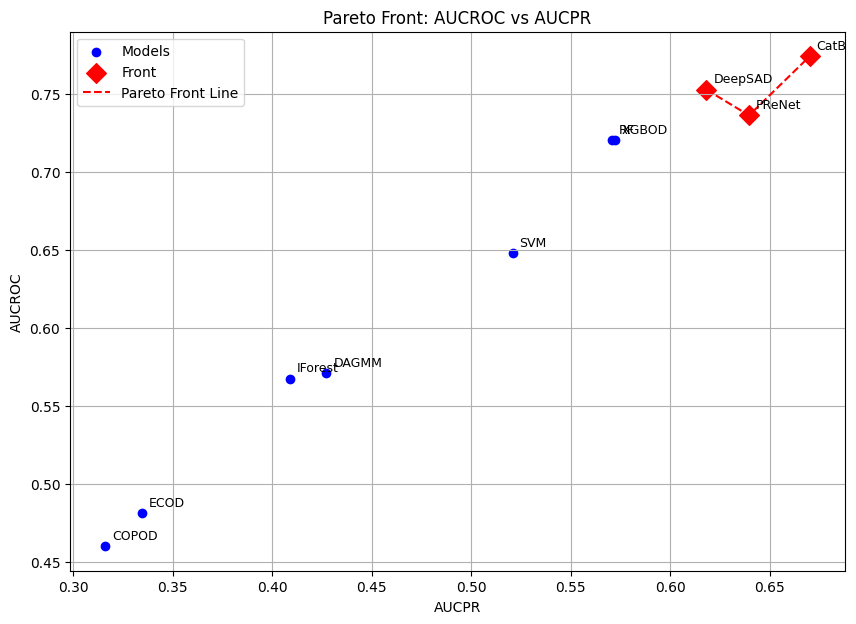

In [7]:
%matplotlib inline
# Plot the Pareto fronts, specifying the fronts to plot

pareto.plot_pareto_fronts(labels=['AUCPR', 'AUCROC'], title="Pareto Front: AUCROC vs AUCPR",
                          annotate=True, fronts_to_plot=[0, 1])


In [8]:
#  Ensemble learning
from sklearn.model_selection import train_test_split

# Concatenation of existing training and test data
X = np.concatenate((data['X_train'], data['X_test']))
y = np.concatenate((data['y_train'], data['y_test']))

# training, validation and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=seed)

print(f"Taille de X_train: {X_train.shape}")
print(f"Taille de X_val: {X_val.shape}")
print(f"Taille de X_test: {X_test.shape}")

Taille de X_train: (1164, 27)
Taille de X_val: (388, 27)
Taille de X_test: (389, 27)


In [9]:
model_names = top2_models_df['Model'].tolist()[:2]  # Sélectionne les deux premiers sur le front de pareto aucroc vs execution_time

# Initialization of basic models
models = {}
for name in model_names:
    clf_class = model_dict[name]
    clf = clf_class(seed=seed, model_name=name)
    clf.fit(X_train, y_train)
    models[name] = clf

Learning rate set to 0.010992
0:	learn: 0.6815389	total: 5.44ms	remaining: 5.44s
1:	learn: 0.6718057	total: 10.7ms	remaining: 5.36s
2:	learn: 0.6630860	total: 14.5ms	remaining: 4.81s
3:	learn: 0.6547216	total: 18.6ms	remaining: 4.63s
4:	learn: 0.6458444	total: 22.8ms	remaining: 4.54s
5:	learn: 0.6370516	total: 26.6ms	remaining: 4.41s
6:	learn: 0.6301744	total: 30.7ms	remaining: 4.35s
7:	learn: 0.6227809	total: 35.7ms	remaining: 4.42s
8:	learn: 0.6150869	total: 40.4ms	remaining: 4.45s
9:	learn: 0.6082723	total: 46ms	remaining: 4.56s
10:	learn: 0.6004741	total: 50ms	remaining: 4.49s
11:	learn: 0.5936937	total: 56.8ms	remaining: 4.67s
12:	learn: 0.5871238	total: 62.4ms	remaining: 4.73s
13:	learn: 0.5795345	total: 65.8ms	remaining: 4.63s
14:	learn: 0.5735765	total: 71.1ms	remaining: 4.67s
15:	learn: 0.5678298	total: 73.5ms	remaining: 4.52s
16:	learn: 0.5620414	total: 77.1ms	remaining: 4.46s
17:	learn: 0.5553276	total: 80.6ms	remaining: 4.4s
18:	learn: 0.5485829	total: 85ms	remaining: 4.39s

In [10]:
val_preds = pd.DataFrame()
for name, model in models.items():
    scores = model.predict_score(X_val)
    val_preds[name] = scores

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Training of the meta-model
meta_model = LogisticRegression(random_state=seed)
#meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(val_preds, y_val)

LogisticRegression(random_state=42)

In [12]:
# Basic model predictions on the test set
test_preds = pd.DataFrame()
for name, model in models.items():
    scores = model.predict_score(X_test)
    test_preds[name] = scores

# Final predictions of the meta-model
final_scores = meta_model.predict_proba(test_preds)[:, 1]

# performance evaluation
result = utils.metric(y_true=y_test, y_score=final_scores)

new_row = pd.DataFrame({
            'Model': ['Stacked Model LR'],
            'AUCROC': [result['aucroc']],
            'AUCPR': [result['aucpr']]
        })
df_results = pd.concat([df_results, new_row], ignore_index=True)

print("Performance of the stacked model :")
print(f"AUCROC: {result['aucroc']}")
print(f"AUCPR: {result['aucpr']}")

Performance of the stacked model :
AUCROC: 0.7620648259303722
AUCPR: 0.29638303797985766


In [13]:
# Comparison between the meta-model and individual models
df_results = df_results.sort_values(by='AUCROC', ascending=False).reset_index(drop=True)

df_results

,Model,AUCROC,AUCPR
0,CatB,0.773901,0.670142
1,Stacked Model LR,0.762065,0.296383
2,DeepSAD,0.752449,0.618186
3,PReNet,0.736000,0.639592
4,XGBOD,0.720317,0.572156
5,RF,0.720297,0.570844
6,SVM,0.647540,0.520713
7,DAGMM,0.570892,0.427181
8,IForest,0.567306,0.408845
9,ECOD,0.481212,0.334607


In [14]:

# def is_pareto_efficient(costs):
#     """
#     Identify Pareto-efficient points.
#     Args:
#         costs (ndarray): Array of shape (n_points, n_costs) where each row is a point.
#     Returns:
#         mask (ndarray): Boolean array indicating whether each point is Pareto-efficient.
#     """
#     is_efficient = np.ones(costs.shape[0], dtype=bool)
#     for i, c in enumerate(costs):
#         if is_efficient[i]:
#             is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
#             is_efficient[i] = True
#     return is_efficient

In [15]:
# # Transformation: maximize AUCROC (we convert it to a minimization problem by taking its negative) and minimize Execution_Time.
# costs = np.column_stack([-df_results['AUCROC'].values, -df_results['AUCPR'].values])
# pareto_mask = is_pareto_efficient(costs)
# pareto_front = df_results[pareto_mask].copy()

# pareto_df = df_results[pareto_mask]
# 
# print("Pareto Front Models:")
# print(pareto_front)


In [16]:
# # Sort Pareto front: first by AUCROC (descending) then by Execution_Time (ascending)
# pareto_front_sorted = pareto_front.sort_values(by=['AUCROC', 'AUCPR'], ascending=[False, True])

# # Select the top 2 models from the Pareto front
# top2_models_df = pareto_front_sorted.head(2).reset_index(drop=True)

# print("Top 2 Pareto Front Models:")
# print(top2_models_df)


In [17]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(8,6))
# plt.scatter(df_results['AUCPR'], df_results['AUCROC'], color='blue', label='Models')
# plt.scatter(pareto_df['AUCPR'], pareto_df['AUCROC'], color='red', marker='D', s=100, label='Pareto Front')

# # Plot the connecting line for the Pareto front
# pareto_df_sorted = pareto_df.sort_values(by='AUCPR')
# plt.plot(pareto_df_sorted['AUCPR'], pareto_df_sorted['AUCROC'], color='red', linestyle='--', label='Pareto Line')

# # Annotate each point with the model name
# for idx, row in df_results.iterrows():
#     plt.annotate(row['Model'], (row['AUCPR'], row['AUCROC']),
#                  textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)

# plt.xlabel("AUCPR")
# plt.ylabel("AUCROC")
# plt.title("Pareto Front: AUCROC vs AUCPR")
# plt.legend()
# plt.grid(True)
# plt.show()